## 引用套件

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend

In [45]:
%matplotlib inline

## 讀取MNIST 數據

In [59]:
# MNIST dataset
(X_train, y_valid), (X_valid, y_valid) = mnist.load_data()


original_dim = 784
X_train = np.reshape(X_train, [-1, original_dim])
X_valid = np.reshape(X_valid, [-1, original_dim])

In [47]:
X_train.shape

(60000, 784)

In [61]:
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

## 檢視MNIST 數據

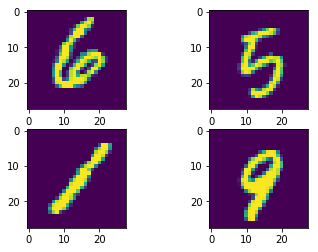

In [49]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

## 建立 Convolution Encoder

### VAE 具有三部分

1. 編碼器可以從隱藏的分佈(latent distribution)中習得平均值與變異數
2. 該分佈取樣的平均值
3. 解碼器可以從取樣的平均值重建圖片

---------------------------

- 編碼器與解碼器都為深度卷積網路

- 產生兩個輸出 隱藏分佈均值latent distribution mean (z_mu) 以及該分佈的變異數 (z_log_sigma).

In [ ]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [50]:
# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## 取樣函數

取樣函數能從我們習得的參數取樣出分佈 
- epsilon 代表一隨機的張量
- VAE 的隱藏空間屬於常態分佈

In [51]:
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

## 建立 Convolution Decoder

In [52]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

## LOSS

- '重建損失' - xent_loss
- 'KL 散度' - kl_loss


In [53]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [54]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
history = vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 237s 4ms/step - loss: 0.2070 - val_loss: 0.1955
Epoch 2/7
  880/60000 [..............................] - ETA: 3:55 - loss: 0.1958

KeyboardInterrupt: 

## 檢視隱藏空間

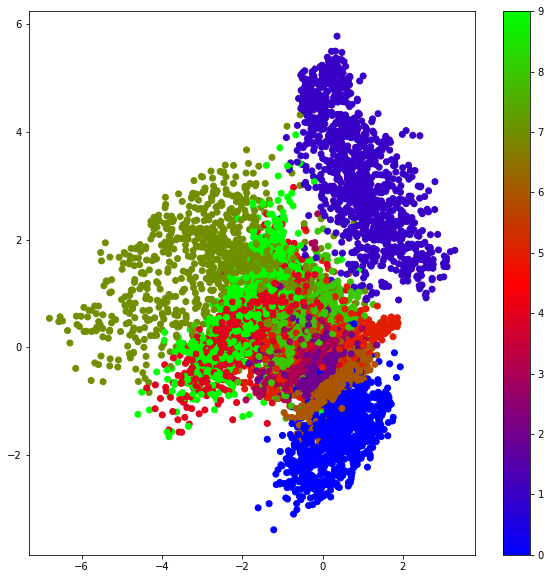

In [62]:
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid, cmap='brg')
plt.colorbar()
plt.show()

## 檢視重建圖

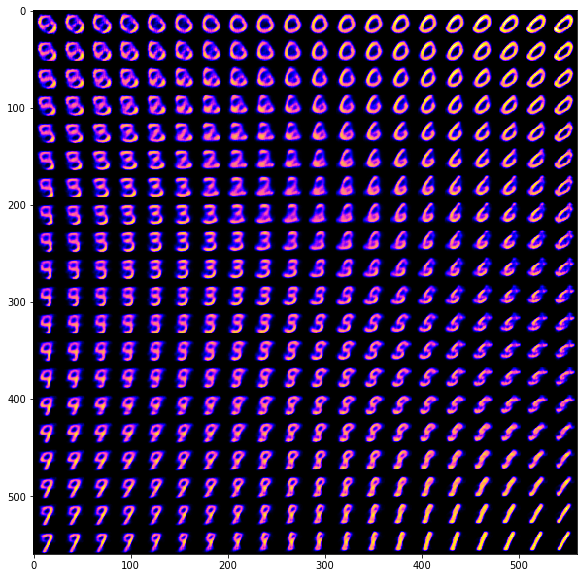

In [63]:
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  